In [1]:

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from itertools import product
from copy import deepcopy
import matplotlib.colors as mcolors



In [2]:

def plot_series(iterations_per_episode, scores_per_episode):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(iterations_per_episode)
    plt.title("Iterations per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Iterations")

    plt.subplot(1, 2, 2)
    plt.plot(scores_per_episode)
    plt.title(f"Score per {PRINT_FREQUENCY} Episodes")
    plt.xlabel(f"Episodes time {PRINT_FREQUENCY}")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()


In [3]:
def plot_game_board(grid):
    """
    Visualizes the game board using matplotlib.

    Args:
    - grid (2D list): The game grid.
    """
    
    # Convert the grid to numpy array for easier indexing
    grid = np.array(grid)

    # Define a colormap: list of color names
    cmap = mcolors.ListedColormap(['white', 'yellow', 'green', 'red', 'black'])  # The order has been adjusted based on the value assignments below.
    
    # Set the bounds for the colormap
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap, norm=norm)

    # Hide the axis
    ax.axis('off')
    
    plt.show()

In [4]:
# Editable Globals
PLAYABLE_GRID_SIZE = 10 # Playable grid without walls.  Minimum value = 5


WALL_PENALTY = -10
MOVEMENT_BONUS = 0
APPLE_BONUS = 20
WIN_BONUS = -0
DIST_TO_APPLE_NUMERATOR = 10
STARTING_SCORE = 10


DECAY_RATE = (1 - 1e-6)
LEARNING_RATE = 1e-1
EPSILON = 9 * 1e-1
PRINT_FREQUENCY = 2**12
BUFFER_SIZE = 4096
BATCH_SIZE = 8192
GAMMA = 0.99
EPISODES = 2**18
SEED = 42

# These globals are derived, don't edit unless refactoring
TOTAL_GRID_SIZE = PLAYABLE_GRID_SIZE + 2             # Playable Area + Walls
MAX_SNAKE_LENGTH = PLAYABLE_GRID_SIZE ** 2 - 1

EMPTY_GRID_SET = set((i, j) for i, j in product(range(1, TOTAL_GRID_SIZE - 1), repeat=2))

## initialize blank grid with empty squares (0) and walls (4)
EMPTY_STATE_NESTED_LIST = [[0 for _ in range(TOTAL_GRID_SIZE)] for _ in range(TOTAL_GRID_SIZE)]
for i in range(TOTAL_GRID_SIZE):
    EMPTY_STATE_NESTED_LIST[0][i] = EMPTY_STATE_NESTED_LIST[i][0] = EMPTY_STATE_NESTED_LIST[TOTAL_GRID_SIZE -1][i] = EMPTY_STATE_NESTED_LIST[i][TOTAL_GRID_SIZE - 1] = 4



In [5]:


class Direction(Enum):
    UP =    [1, 0, 0, 0]
    DOWN =  [0, 1, 0, 0]
    LEFT =  [0, 0, 1, 0]
    RIGHT = [0, 0, 0, 1]


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def eat_apple(snake_queue):
    """
    Generate a new apple location that's not within the snake's current position.

    Args:
    - snake_queue (list): List of tuples representing the snake's current positions.

    Returns:
    - tuple: New apple location.
    """
    available_locations = EMPTY_GRID_SET - set(snake_queue)
    new_apple_location = random.choice(list(available_locations))
    return new_apple_location

def initialize_game(starting_head_location, starting_apple_location):
    """
    Initialize the snake's starting position and the first apple's position.

    Returns:
    - snake_queue (list): List of tuples representing the snake's initial position.
    - apple_location (tuple): Initial apple location.
    """
    # Initialize the snake queue with the head location
    snake_queue = [starting_head_location]
    apple_location = starting_apple_location
    score = STARTING_SCORE
    distance_to_apple = ((starting_head_location[0]-starting_apple_location[0])**2 + (starting_head_location[1]-starting_apple_location[1])**2)**0.5
    distance_traveled_to_apple = 0
    game_over = False
    return game_over, snake_queue, apple_location, distance_traveled_to_apple, distance_to_apple, score

def update_state(snake_queue, apple_location, distance_traveled_to_apple, direction, score):
    """
    Update the snake's position based on the given direction.
    """
    
    def move_snake(snake_queue, direction):
        head_location = snake_queue[-1]
        # Update head_location based on the direction
        if direction == Direction.UP: # Up
            head_location = (head_location[0]-1, head_location[1])
        elif direction == Direction.DOWN: # Down
            head_location = (head_location[0]+1, head_location[1])
        elif direction == Direction.LEFT: # Left
            head_location = (head_location[0], head_location[1]-1)
        else: # Right
            head_location = (head_location[0], head_location[1]+1)
        return head_location

    def score_and_process_move(head_location, snake_queue, apple_location, distance_traveled_to_apple, score):
        # Check if snake ate itself or a wall
        distance_traveled_to_apple += 1
        distance_to_apple = ((head_location[0]-apple_location[0])**2 + (head_location[1]-apple_location[1])**2)**0.5

        if (head_location in snake_queue) or (head_location[0] in [0, TOTAL_GRID_SIZE - 1] or head_location[1] in [0, TOTAL_GRID_SIZE - 1]):
            score += WALL_PENALTY
            return True, snake_queue, apple_location, distance_traveled_to_apple, score
        # Check if snake ate apple
        elif head_location == apple_location:
            score += APPLE_BONUS 
            apple_location = eat_apple(snake_queue)
            snake_queue.append(head_location)
            distance_traveled_to_apple = 0
        # Snake just moves
        else:
            score += MOVEMENT_BONUS
            score += DIST_TO_APPLE_NUMERATOR // distance_to_apple
            snake_queue.append(head_location)
            snake_queue.pop(0)
        if len(snake_queue) == MAX_SNAKE_LENGTH:
            score += WIN_BONUS
            return True, snake_queue, apple_location, distance_traveled_to_apple, score
        return False, snake_queue, apple_location, distance_traveled_to_apple, score

    return score_and_process_move(move_snake(snake_queue, direction), snake_queue, apple_location, distance_traveled_to_apple, score)


In [6]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(
            *random.sample(self.buffer, batch_size))
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    
    def __len__(self):
        return len(self.buffer)

In [8]:
class DQNAgent:
    def __init__(self, input_dim, output_dim, gamma=GAMMA, learning_rate=LEARNING_RATE, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
        self.dqn = DQN(input_dim, output_dim).to(device)
        self.target = DQN(input_dim, output_dim).to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval() # Set the target network to evaluation mode
        
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = EPSILON
    
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)
        
        # Convert to tensors
        state = torch.FloatTensor(state).to(device)
        action = torch.LongTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).to(device)
        
        # Compute Q-values
        curr_Q = self.dqn(state).gather(1, action.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.target(next_state).max(1)[0]
        expected_Q = reward + (1 - done) * self.gamma * next_Q
        
        # Compute loss and update the network
        loss = self.loss_fn(curr_Q, expected_Q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            if random.random() > self.epsilon:
                action_index = int(self.dqn(state).max(1)[1])
            else:
                action_index = random.randint(0, 3) # Number of actions - 1

        # Map action_index to Direction enum
        
        return action_index

                
    def decay_epsilon(self):
        self.epsilon *= DECAY_RATE
        self.epsilon = max(self.epsilon, 0.01)

        # Decay the learning rate
        #self.optimizer.param_groups[0]['lr'] *= DECAY_RATE

    def get_epsilon(self):
        return self.epsilon
    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']        
    def sync_target(self):
        self.target.load_state_dict(self.dqn.state_dict())

In [9]:
def encode_state(snake_queue, apple_location, distance_traveled_to_apple, score):
    
    grid = [row[:] for row in EMPTY_STATE_NESTED_LIST]
    head = snake_queue[-1]
    grid[head[0]][head[1]] = 1
    for segment in snake_queue:
        grid[segment[0]][segment[1]] = 2

    grid[apple_location[0]][apple_location[1]] = 3



    # Distance to nearest obstacle
    distances_to_obstacle = {
        "left": head[1],
        "right": TOTAL_GRID_SIZE - 1 - head[1],
        "up": head[0],
        "down": TOTAL_GRID_SIZE - 1 - head[0]
    }
    
    for segment in snake_queue:
        if segment[0] == head[0]:  # Same row as head
            if 0 < segment[1] - head[1] < distances_to_obstacle["right"]:  # Segment is to the right of head
                distances_to_obstacle["right"] = segment[1] - head[1] - 1
            elif 0 < head[1] - segment[1] < distances_to_obstacle["left"]:  # Segment is to the left of head
                distances_to_obstacle["left"] = head[1] - segment[1] - 1
                
        if segment[1] == head[1]:  # Same column as head
            if 0 < segment[0] - head[0] < distances_to_obstacle["down"]:  # Segment is below head
                distances_to_obstacle["down"] = segment[0] - head[0] - 1
            elif 0 < head[0] - segment[0] < distances_to_obstacle["up"]:  # Segment is above head
                distances_to_obstacle["up"] = head[0] - segment[0] - 1

    # Distance to apple (vertical and horizontal)
    apple_dist = {
        "horizontal": apple_location[1] - head[1],
        "vertical": apple_location[0] - head[0]
    }
    
    flat_grid = [cell for row in grid for cell in row]
    
    state = flat_grid + [distances_to_obstacle[dir] for dir in ["left", "right", "up", "down"]] + [apple_dist["horizontal"], apple_dist["vertical"]]
    
    return state


Number of GPUs: 0
Device: cpu
Episode: 4095 
        Avg Iterations (last 4096 episodes): 16.05 
        Avg Score (last 4096): 34.2068 
        SnakeLength: 1.098388671875 
        Eplsilon: 0.8963220339360848 
        Learning Rate: 0.1
        


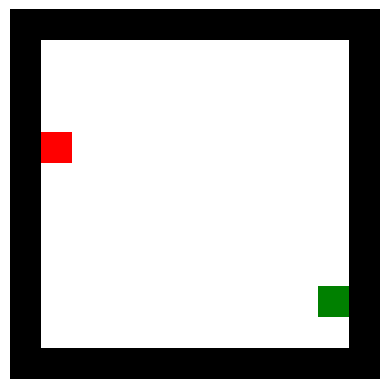

Episode: 8191 
        Avg Iterations (last 4096 episodes): 16.65 
        Avg Score (last 4096): 35.7051 
        SnakeLength: 1.1005859375 
        Eplsilon: 0.8926582056957006 
        Learning Rate: 0.1
        


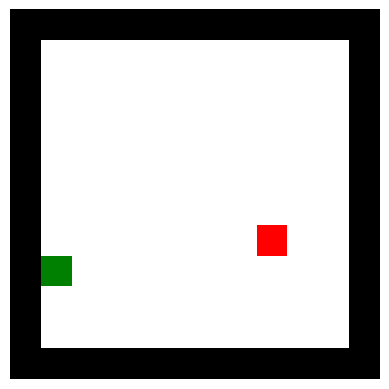

Episode: 12287 
        Avg Iterations (last 4096 episodes): 16.33 
        Avg Score (last 4096): 34.1860 
        SnakeLength: 1.096923828125 
        Eplsilon: 0.8890093538107648 
        Learning Rate: 0.1
        


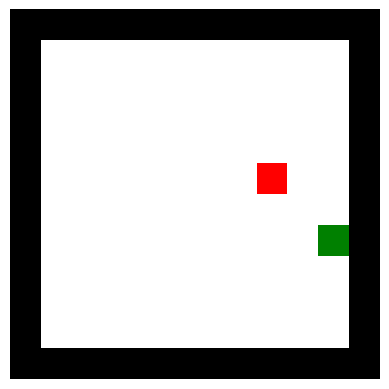

Episode: 16383 
        Avg Iterations (last 4096 episodes): 16.44 
        Avg Score (last 4096): 34.3936 
        SnakeLength: 1.09130859375 
        Eplsilon: 0.8853754170635548 
        Learning Rate: 0.1
        


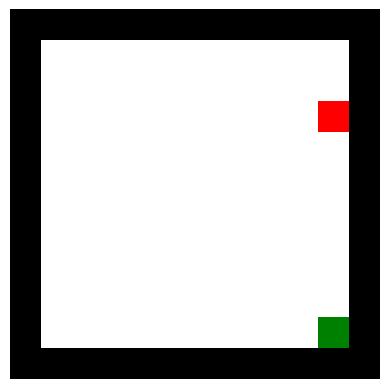

Episode: 20479 
        Avg Iterations (last 4096 episodes): 16.17 
        Avg Score (last 4096): 33.7722 
        SnakeLength: 1.089599609375 
        Eplsilon: 0.8817563344865778 
        Learning Rate: 0.1
        


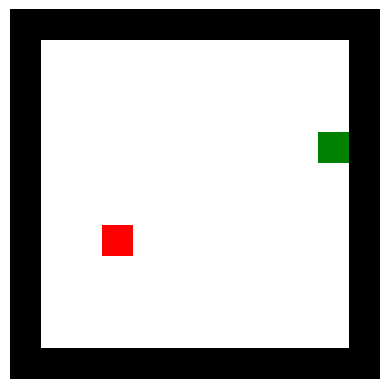

Episode: 24575 
        Avg Iterations (last 4096 episodes): 16.01 
        Avg Score (last 4096): 34.8091 
        SnakeLength: 1.104736328125 
        Eplsilon: 0.8781520453615635 
        Learning Rate: 0.1
        


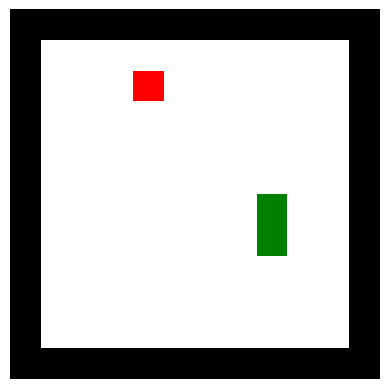

Episode: 28671 
        Avg Iterations (last 4096 episodes): 15.76 
        Avg Score (last 4096): 33.4365 
        SnakeLength: 1.1025390625 
        Eplsilon: 0.8745624892184263 
        Learning Rate: 0.1
        


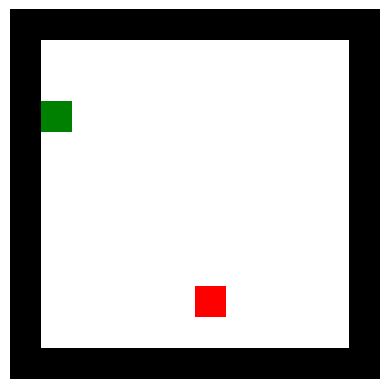

Episode: 32767 
        Avg Iterations (last 4096 episodes): 15.61 
        Avg Score (last 4096): 33.2593 
        SnakeLength: 1.098388671875 
        Eplsilon: 0.870987605834262 
        Learning Rate: 0.1
        


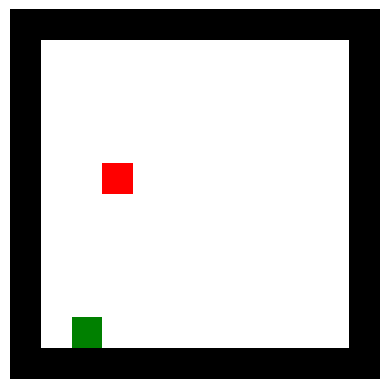

Episode: 36863 
        Avg Iterations (last 4096 episodes): 15.63 
        Avg Score (last 4096): 32.5215 
        SnakeLength: 1.09765625 
        Eplsilon: 0.8674273352323396 
        Learning Rate: 0.1
        


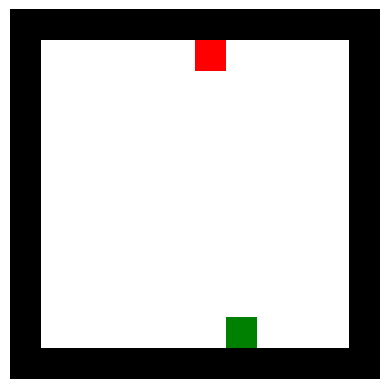

Episode: 40959 
        Avg Iterations (last 4096 episodes): 15.95 
        Avg Score (last 4096): 33.1238 
        SnakeLength: 1.0888671875 
        Eplsilon: 0.8638816176810846 
        Learning Rate: 0.1
        


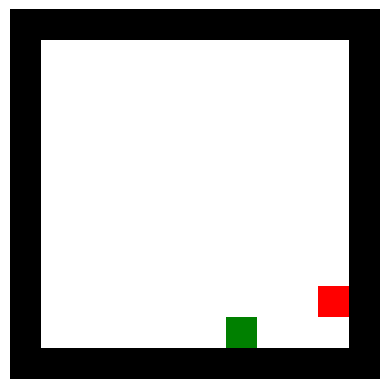

Episode: 45055 
        Avg Iterations (last 4096 episodes): 14.96 
        Avg Score (last 4096): 30.9814 
        SnakeLength: 1.088134765625 
        Eplsilon: 0.8603503936930882 
        Learning Rate: 0.1
        


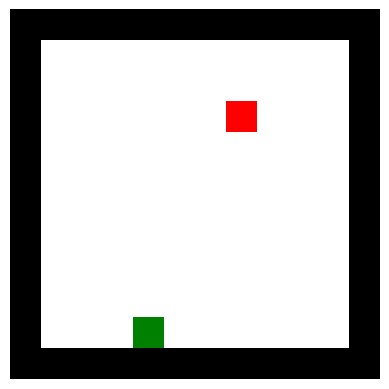

Episode: 49151 
        Avg Iterations (last 4096 episodes): 16.04 
        Avg Score (last 4096): 32.8667 
        SnakeLength: 1.089111328125 
        Eplsilon: 0.8568336040240981 
        Learning Rate: 0.1
        


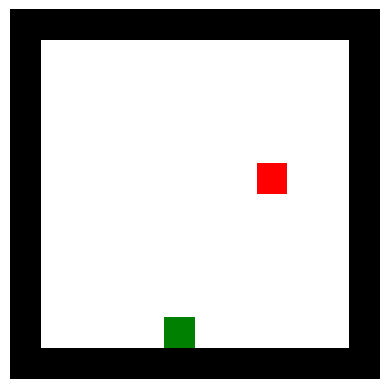

Episode: 53247 
        Avg Iterations (last 4096 episodes): 15.60 
        Avg Score (last 4096): 32.7727 
        SnakeLength: 1.087646484375 
        Eplsilon: 0.853331189672033 
        Learning Rate: 0.1
        


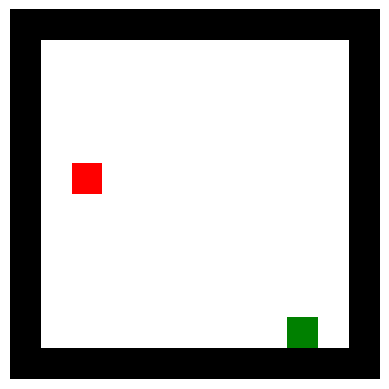

Episode: 57343 
        Avg Iterations (last 4096 episodes): 15.41 
        Avg Score (last 4096): 31.8091 
        SnakeLength: 1.090576171875 
        Eplsilon: 0.8498430918759871 
        Learning Rate: 0.1
        


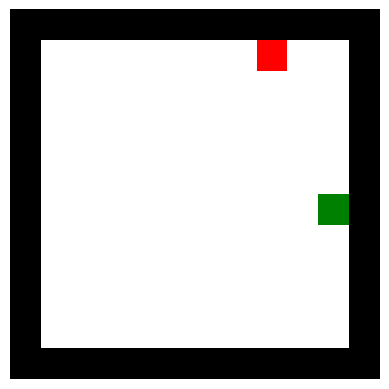

Episode: 61439 
        Avg Iterations (last 4096 episodes): 15.37 
        Avg Score (last 4096): 32.2190 
        SnakeLength: 1.08935546875 
        Eplsilon: 0.8463692521152568 
        Learning Rate: 0.1
        


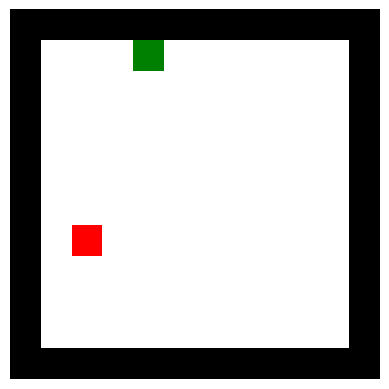

Episode: 65535 
        Avg Iterations (last 4096 episodes): 15.55 
        Avg Score (last 4096): 32.9885 
        SnakeLength: 1.096923828125 
        Eplsilon: 0.8429096121083343 
        Learning Rate: 0.1
        


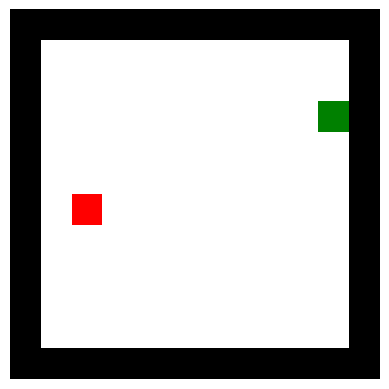

Episode: 69631 
        Avg Iterations (last 4096 episodes): 15.39 
        Avg Score (last 4096): 31.7107 
        SnakeLength: 1.08642578125 
        Eplsilon: 0.8394641138119574 
        Learning Rate: 0.1
        


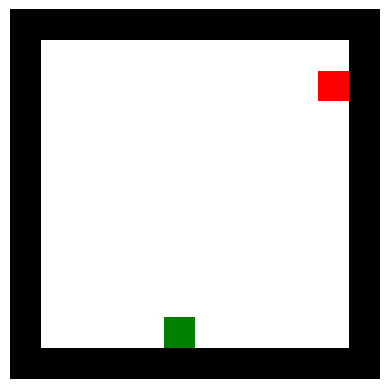

Episode: 73727 
        Avg Iterations (last 4096 episodes): 14.96 
        Avg Score (last 4096): 31.1428 
        SnakeLength: 1.083251953125 
        Eplsilon: 0.8360326994201186 
        Learning Rate: 0.1
        


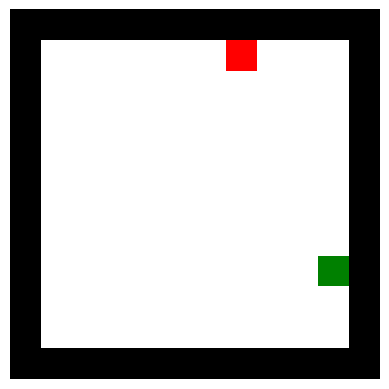

Episode: 77823 
        Avg Iterations (last 4096 episodes): 15.21 
        Avg Score (last 4096): 32.2004 
        SnakeLength: 1.0908203125 
        Eplsilon: 0.8326153113630999 
        Learning Rate: 0.1
        


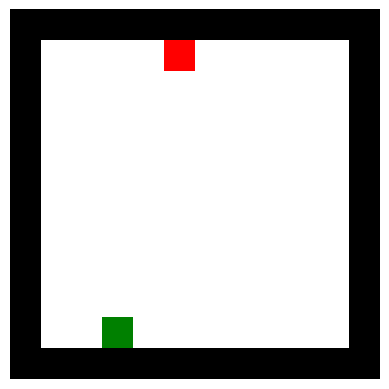

Episode: 81919 
        Avg Iterations (last 4096 episodes): 14.50 
        Avg Score (last 4096): 30.3428 
        SnakeLength: 1.095458984375 
        Eplsilon: 0.8292118923065027 
        Learning Rate: 0.1
        


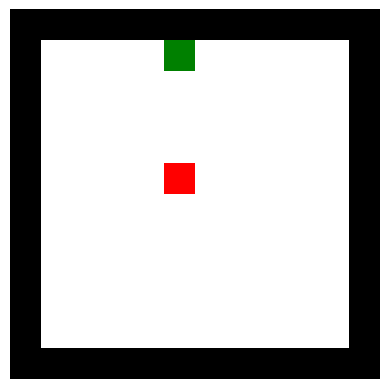

Episode: 86015 
        Avg Iterations (last 4096 episodes): 14.84 
        Avg Score (last 4096): 31.7329 
        SnakeLength: 1.093994140625 
        Eplsilon: 0.8258223851502953 
        Learning Rate: 0.1
        


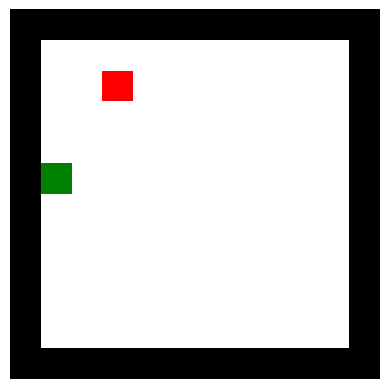

Episode: 90111 
        Avg Iterations (last 4096 episodes): 14.86 
        Avg Score (last 4096): 30.5518 
        SnakeLength: 1.08251953125 
        Eplsilon: 0.8224467330278428 
        Learning Rate: 0.1
        


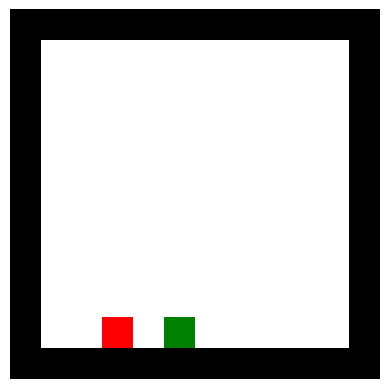

Episode: 94207 
        Avg Iterations (last 4096 episodes): 14.95 
        Avg Score (last 4096): 31.5483 
        SnakeLength: 1.0927734375 
        Eplsilon: 0.8190848793049749 
        Learning Rate: 0.1
        


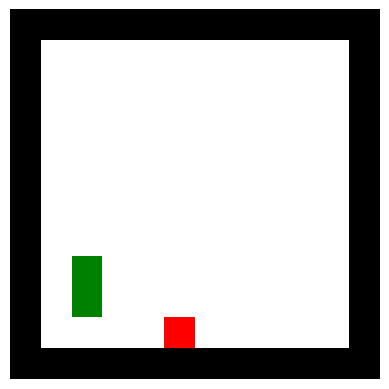

Episode: 98303 
        Avg Iterations (last 4096 episodes): 14.15 
        Avg Score (last 4096): 29.5994 
        SnakeLength: 1.079833984375 
        Eplsilon: 0.8157367675790016 
        Learning Rate: 0.1
        


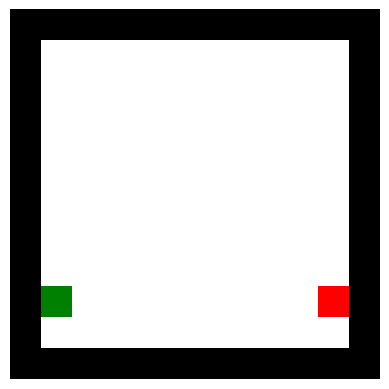

Episode: 102399 
        Avg Iterations (last 4096 episodes): 14.33 
        Avg Score (last 4096): 29.6672 
        SnakeLength: 1.083740234375 
        Eplsilon: 0.8124023416777981 
        Learning Rate: 0.1
        


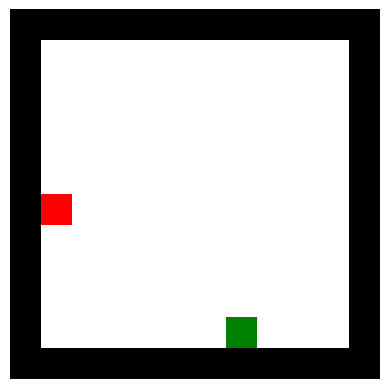

Episode: 106495 
        Avg Iterations (last 4096 episodes): 14.33 
        Avg Score (last 4096): 29.5486 
        SnakeLength: 1.07470703125 
        Eplsilon: 0.8090815456588489 
        Learning Rate: 0.1
        


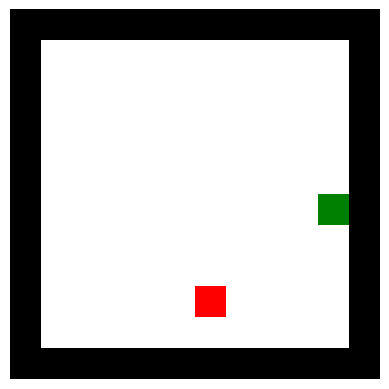

Episode: 110591 
        Avg Iterations (last 4096 episodes): 14.64 
        Avg Score (last 4096): 30.6179 
        SnakeLength: 1.083740234375 
        Eplsilon: 0.8057743238083013 
        Learning Rate: 0.1
        


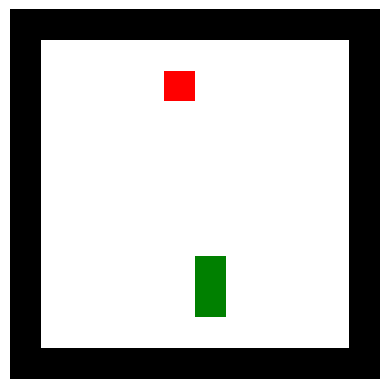

Episode: 114687 
        Avg Iterations (last 4096 episodes): 13.91 
        Avg Score (last 4096): 28.7380 
        SnakeLength: 1.08837890625 
        Eplsilon: 0.8024806206400582 
        Learning Rate: 0.1
        


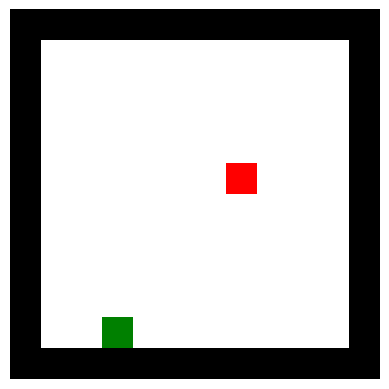

Episode: 118783 
        Avg Iterations (last 4096 episodes): 14.20 
        Avg Score (last 4096): 30.2112 
        SnakeLength: 1.096435546875 
        Eplsilon: 0.7992003808948088 
        Learning Rate: 0.1
        


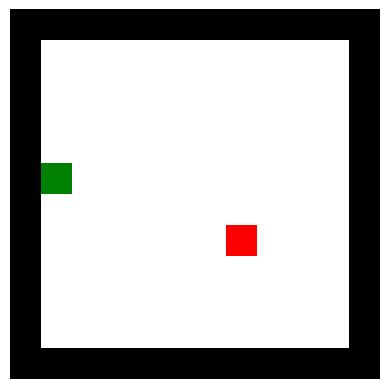

Episode: 122879 
        Avg Iterations (last 4096 episodes): 13.75 
        Avg Score (last 4096): 28.4126 
        SnakeLength: 1.08642578125 
        Eplsilon: 0.7959335495391311 
        Learning Rate: 0.1
        


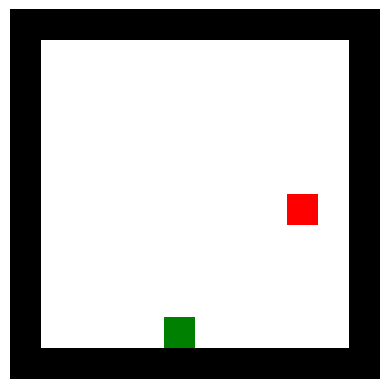

Episode: 126975 
        Avg Iterations (last 4096 episodes): 13.91 
        Avg Score (last 4096): 28.8713 
        SnakeLength: 1.087158203125 
        Eplsilon: 0.7926800717645609 
        Learning Rate: 0.1
        


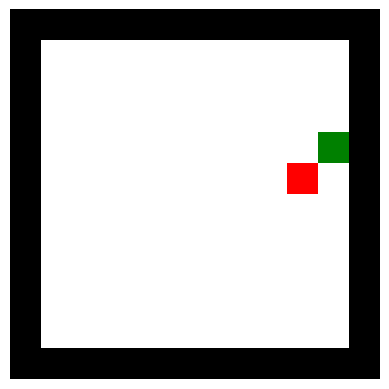

Episode: 131071 
        Avg Iterations (last 4096 episodes): 14.17 
        Avg Score (last 4096): 29.9204 
        SnakeLength: 1.086669921875 
        Eplsilon: 0.7894398929866692 
        Learning Rate: 0.1
        


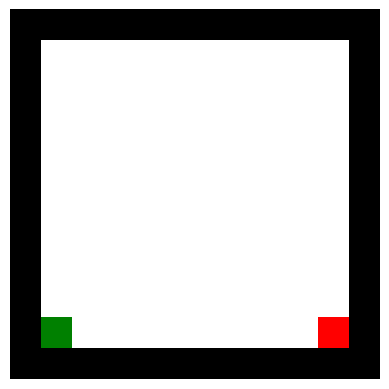

Episode: 135167 
        Avg Iterations (last 4096 episodes): 13.92 
        Avg Score (last 4096): 28.6726 
        SnakeLength: 1.087890625 
        Eplsilon: 0.7862129588441364 
        Learning Rate: 0.1
        


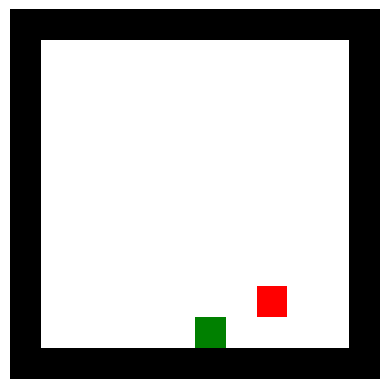

Episode: 139263 
        Avg Iterations (last 4096 episodes): 13.57 
        Avg Score (last 4096): 27.9211 
        SnakeLength: 1.078857421875 
        Eplsilon: 0.7829992151978771 
        Learning Rate: 0.1
        


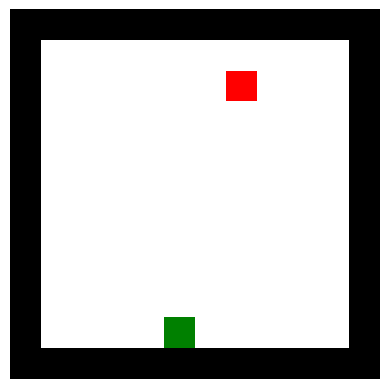

Episode: 143359 
        Avg Iterations (last 4096 episodes): 13.36 
        Avg Score (last 4096): 27.8560 
        SnakeLength: 1.083984375 
        Eplsilon: 0.7797986081300781 
        Learning Rate: 0.1
        


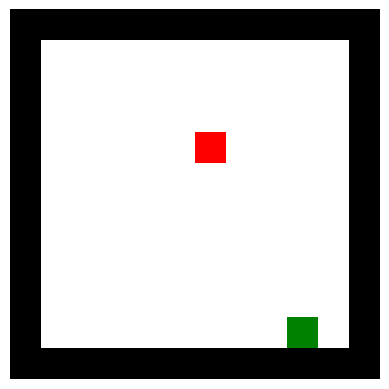

Episode: 147455 
        Avg Iterations (last 4096 episodes): 13.55 
        Avg Score (last 4096): 28.3838 
        SnakeLength: 1.08154296875 
        Eplsilon: 0.7766110839433421 
        Learning Rate: 0.1
        


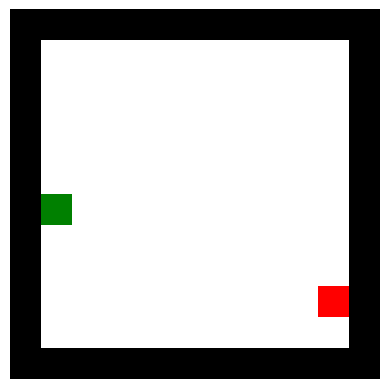

Episode: 151551 
        Avg Iterations (last 4096 episodes): 13.57 
        Avg Score (last 4096): 28.3496 
        SnakeLength: 1.079345703125 
        Eplsilon: 0.773436589159757 
        Learning Rate: 0.1
        


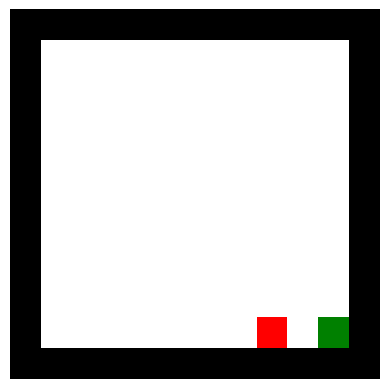

Episode: 155647 
        Avg Iterations (last 4096 episodes): 13.29 
        Avg Score (last 4096): 27.3147 
        SnakeLength: 1.07958984375 
        Eplsilon: 0.7702750705200088 
        Learning Rate: 0.1
        


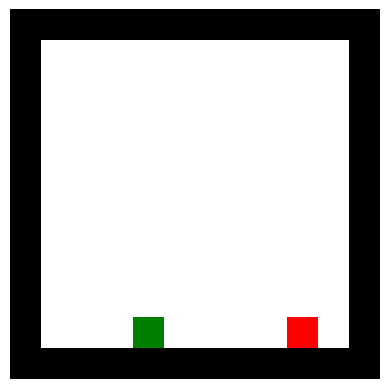

Episode: 159743 
        Avg Iterations (last 4096 episodes): 13.53 
        Avg Score (last 4096): 28.2690 
        SnakeLength: 1.084228515625 
        Eplsilon: 0.7671264749824884 
        Learning Rate: 0.1
        


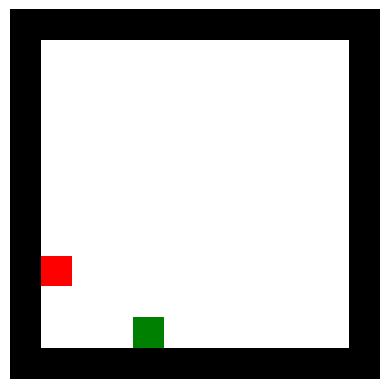

Episode: 163839 
        Avg Iterations (last 4096 episodes): 13.10 
        Avg Score (last 4096): 27.2583 
        SnakeLength: 1.078125 
        Eplsilon: 0.7639907497224052 
        Learning Rate: 0.1
        


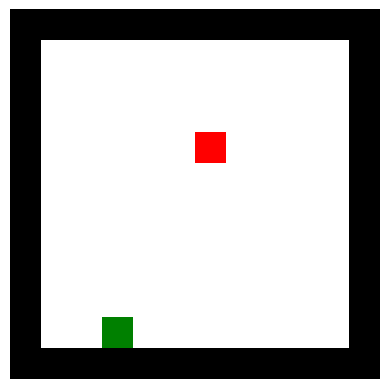

Episode: 167935 
        Avg Iterations (last 4096 episodes): 13.13 
        Avg Score (last 4096): 27.5352 
        SnakeLength: 1.07958984375 
        Eplsilon: 0.7608678421308878 
        Learning Rate: 0.1
        


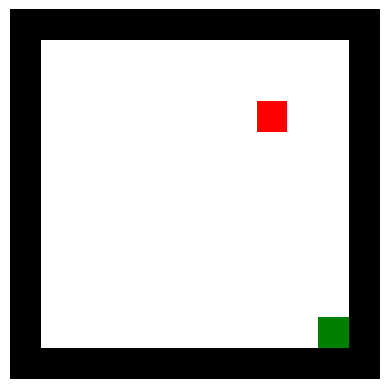

Episode: 172031 
        Avg Iterations (last 4096 episodes): 13.01 
        Avg Score (last 4096): 27.2561 
        SnakeLength: 1.0859375 
        Eplsilon: 0.7577576998141173 
        Learning Rate: 0.1
        


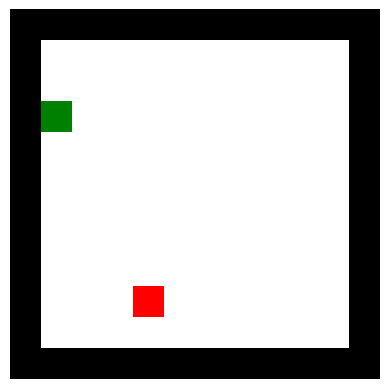

Episode: 176127 
        Avg Iterations (last 4096 episodes): 12.91 
        Avg Score (last 4096): 26.5918 
        SnakeLength: 1.077880859375 
        Eplsilon: 0.7546602705924402 
        Learning Rate: 0.1
        


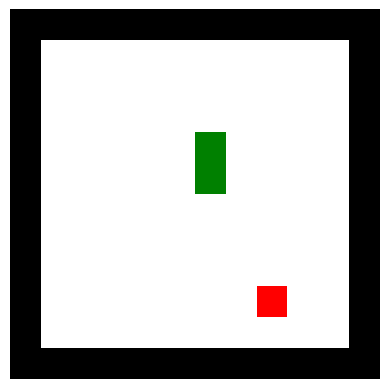

Episode: 180223 
        Avg Iterations (last 4096 episodes): 12.84 
        Avg Score (last 4096): 26.6733 
        SnakeLength: 1.075927734375 
        Eplsilon: 0.7515755024994945 
        Learning Rate: 0.1
        


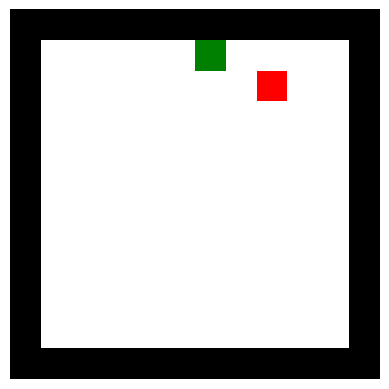

Episode: 184319 
        Avg Iterations (last 4096 episodes): 12.67 
        Avg Score (last 4096): 26.2607 
        SnakeLength: 1.08056640625 
        Eplsilon: 0.7485033437813314 
        Learning Rate: 0.1
        


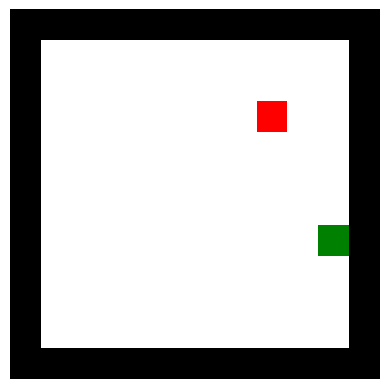

Episode: 188415 
        Avg Iterations (last 4096 episodes): 12.46 
        Avg Score (last 4096): 26.4792 
        SnakeLength: 1.08740234375 
        Eplsilon: 0.7454437428955624 
        Learning Rate: 0.1
        


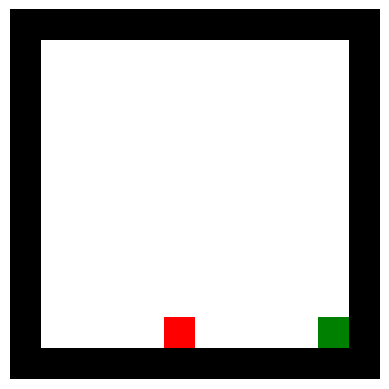

Episode: 192511 
        Avg Iterations (last 4096 episodes): 12.82 
        Avg Score (last 4096): 26.3379 
        SnakeLength: 1.0771484375 
        Eplsilon: 0.7423966485104759 
        Learning Rate: 0.1
        


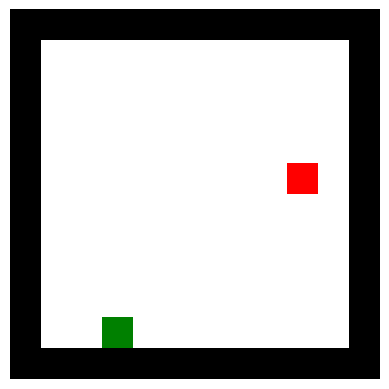

Episode: 196607 
        Avg Iterations (last 4096 episodes): 12.70 
        Avg Score (last 4096): 25.9233 
        SnakeLength: 1.071044921875 
        Eplsilon: 0.7393620095041885 
        Learning Rate: 0.1
        


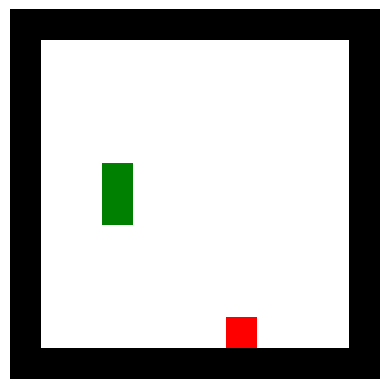

Episode: 200703 
        Avg Iterations (last 4096 episodes): 12.35 
        Avg Score (last 4096): 25.6326 
        SnakeLength: 1.07421875 
        Eplsilon: 0.7363397749637866 
        Learning Rate: 0.1
        


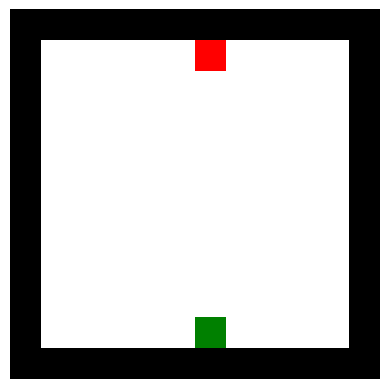

Episode: 204799 
        Avg Iterations (last 4096 episodes): 12.61 
        Avg Score (last 4096): 26.0181 
        SnakeLength: 1.072265625 
        Eplsilon: 0.7333298941844638 
        Learning Rate: 0.1
        


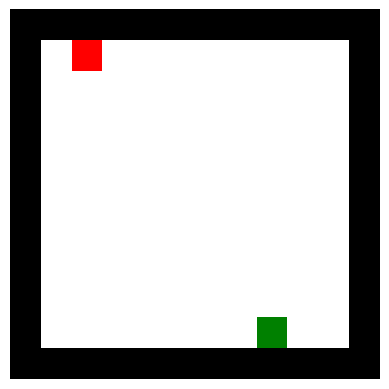

Episode: 208895 
        Avg Iterations (last 4096 episodes): 12.48 
        Avg Score (last 4096): 25.7505 
        SnakeLength: 1.076171875 
        Eplsilon: 0.7303323166686791 
        Learning Rate: 0.1
        


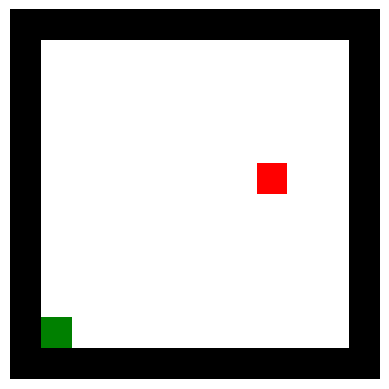

Episode: 212991 
        Avg Iterations (last 4096 episodes): 12.45 
        Avg Score (last 4096): 25.4402 
        SnakeLength: 1.0732421875 
        Eplsilon: 0.7273469921253046 
        Learning Rate: 0.1
        


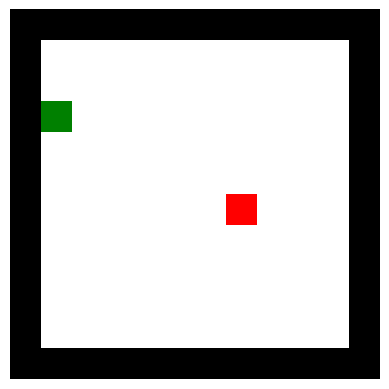

Episode: 217087 
        Avg Iterations (last 4096 episodes): 12.31 
        Avg Score (last 4096): 25.2070 
        SnakeLength: 1.080810546875 
        Eplsilon: 0.724373870468791 
        Learning Rate: 0.1
        


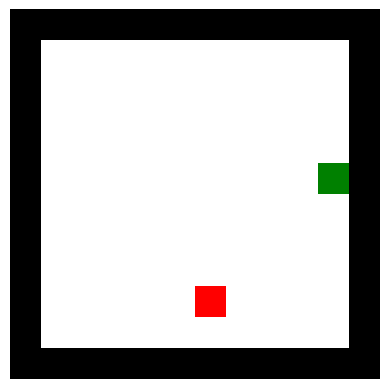

Episode: 221183 
        Avg Iterations (last 4096 episodes): 12.28 
        Avg Score (last 4096): 24.6946 
        SnakeLength: 1.072998046875 
        Eplsilon: 0.7214129018183116 
        Learning Rate: 0.1
        


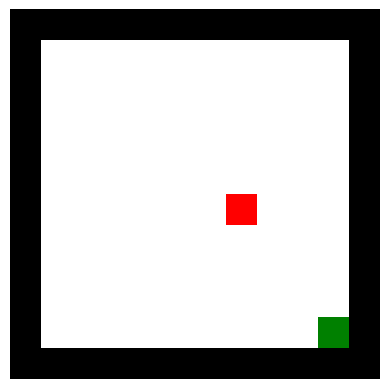

Episode: 225279 
        Avg Iterations (last 4096 episodes): 12.56 
        Avg Score (last 4096): 25.4673 
        SnakeLength: 1.071533203125 
        Eplsilon: 0.718464036496935 
        Learning Rate: 0.1
        


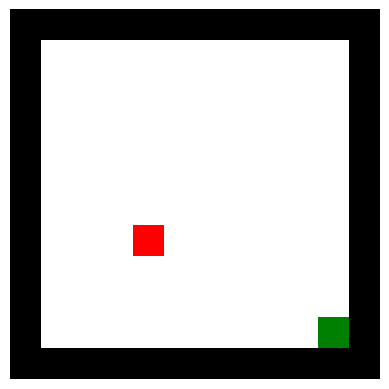

Episode: 229375 
        Avg Iterations (last 4096 episodes): 12.10 
        Avg Score (last 4096): 25.1064 
        SnakeLength: 1.0732421875 
        Eplsilon: 0.715527225030794 
        Learning Rate: 0.1
        


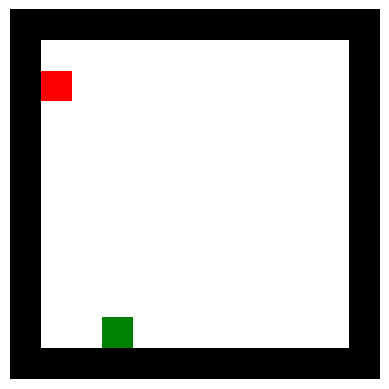

Episode: 233471 
        Avg Iterations (last 4096 episodes): 11.98 
        Avg Score (last 4096): 24.6326 
        SnakeLength: 1.076904296875 
        Eplsilon: 0.7126024181482563 
        Learning Rate: 0.1
        


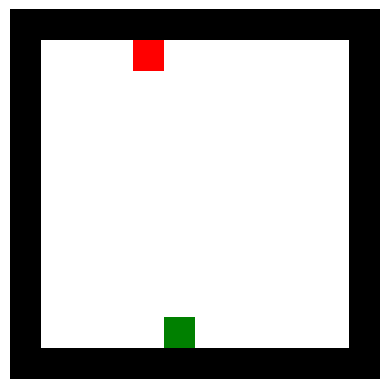

Episode: 237567 
        Avg Iterations (last 4096 episodes): 12.23 
        Avg Score (last 4096): 25.4927 
        SnakeLength: 1.082275390625 
        Eplsilon: 0.7096895667790818 
        Learning Rate: 0.1
        


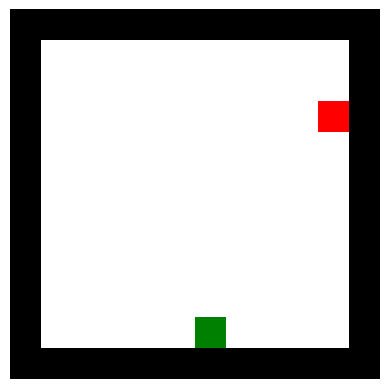

Episode: 241663 
        Avg Iterations (last 4096 episodes): 11.81 
        Avg Score (last 4096): 24.5972 
        SnakeLength: 1.076416015625 
        Eplsilon: 0.7067886220536107 
        Learning Rate: 0.1
        


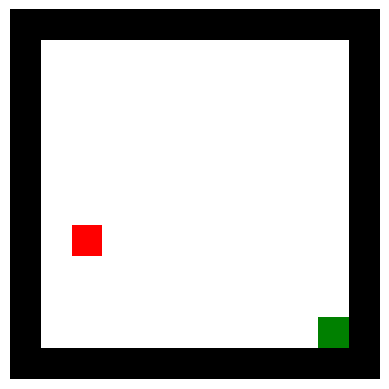

Episode: 245759 
        Avg Iterations (last 4096 episodes): 11.58 
        Avg Score (last 4096): 23.9062 
        SnakeLength: 1.072998046875 
        Eplsilon: 0.7038995353019564 
        Learning Rate: 0.1
        


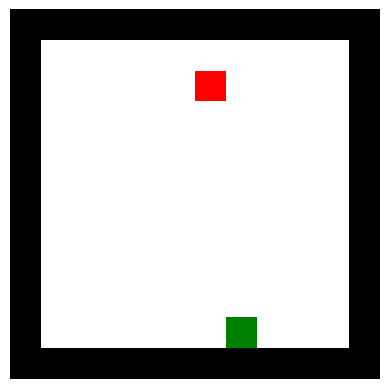

Episode: 249855 
        Avg Iterations (last 4096 episodes): 12.01 
        Avg Score (last 4096): 24.8545 
        SnakeLength: 1.079833984375 
        Eplsilon: 0.7010222580531711 
        Learning Rate: 0.1
        


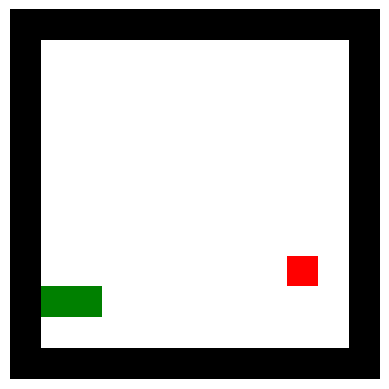

Episode: 253951 
        Avg Iterations (last 4096 episodes): 11.50 
        Avg Score (last 4096): 24.2522 
        SnakeLength: 1.080078125 
        Eplsilon: 0.6981567420344352 
        Learning Rate: 0.1
        


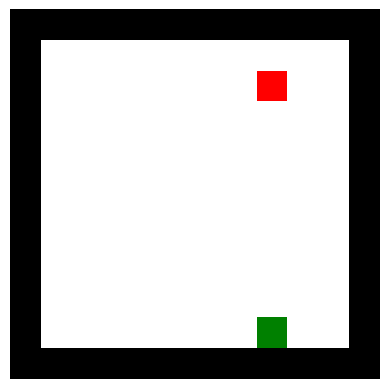

Episode: 258047 
        Avg Iterations (last 4096 episodes): 11.72 
        Avg Score (last 4096): 24.3701 
        SnakeLength: 1.075927734375 
        Eplsilon: 0.6953029391702529 
        Learning Rate: 0.1
        


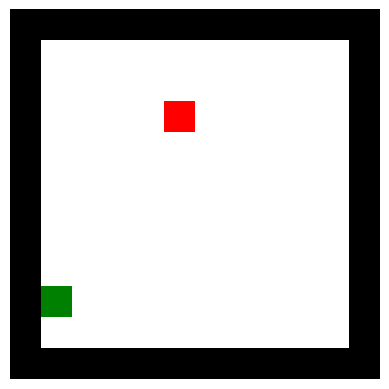

Episode: 262143 
        Avg Iterations (last 4096 episodes): 11.41 
        Avg Score (last 4096): 23.4895 
        SnakeLength: 1.077880859375 
        Eplsilon: 0.6924608015816379 
        Learning Rate: 0.1
        


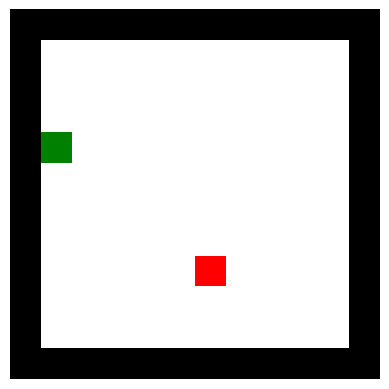

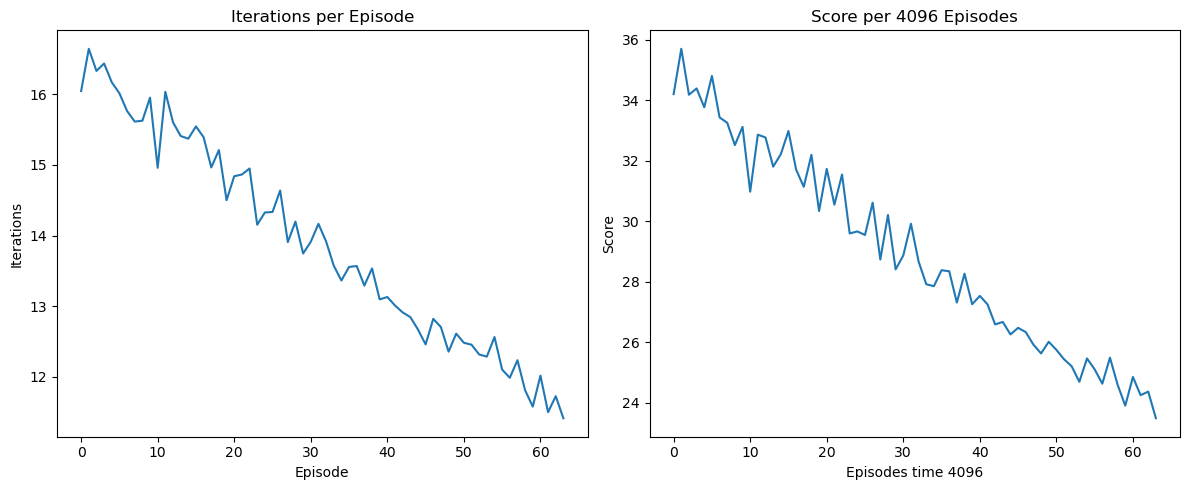

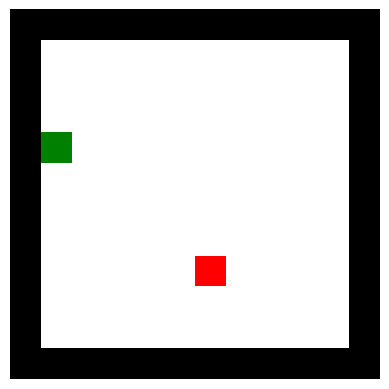

In [10]:
# Hyperparameters

input_dim = TOTAL_GRID_SIZE**2 + 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Number of GPUs: {torch.cuda.device_count()}')
print(f'Device: {device}')
agent = DQNAgent(input_dim=input_dim , output_dim=4) # Fill input dimension
action_mapping = {
            0: Direction.UP,
            1: Direction.DOWN,
            2: Direction.LEFT,
            3: Direction.RIGHT
        }
iterations_plot_list = []
scores_plot_list = []
moving_avg_iterations = deque(maxlen=PRINT_FREQUENCY)
moving_avg_scores = deque(maxlen=PRINT_FREQUENCY)
moving_avg_length = deque(maxlen=PRINT_FREQUENCY)
for episode in range(EPISODES):
    set_seed(SEED + episode)
    starting_head_location = random.choice(list(EMPTY_GRID_SET))
    starting_apple_location = random.choice(list(EMPTY_GRID_SET - set(starting_head_location)))
    iteration_count = 0
    done, snake_queue, apple_location, distance_traveled_to_apple, distance_to_apple, score = initialize_game(starting_head_location, starting_apple_location)
    state = encode_state(snake_queue, apple_location, distance_traveled_to_apple, score)

    while not done:
        iteration_count += 1
        action_index = agent.get_action(state)
        done, snake_queue, apple_location, distance_traveled_to_apple, new_score = update_state(snake_queue, apple_location, distance_traveled_to_apple, action_mapping[action_index], score)
        next_state = encode_state(snake_queue, apple_location, distance_traveled_to_apple, new_score-score)
        agent.buffer.push(next_state, action_index, new_score - score, next_state, done)
        agent.update()
        state = next_state
        #game_grid = [state[i:i+TOTAL_GRID_SIZE] for i in range(0, TOTAL_GRID_SIZE**2, TOTAL_GRID_SIZE)]
        #plot_game_board(game_grid)
        score = new_score
    
    moving_avg_iterations.append(iteration_count)
    moving_avg_scores.append(score)
    moving_avg_length.append(len(snake_queue))
    
    plot_board = True
    if ((episode + 1) % PRINT_FREQUENCY == 0):
        avg_iterations = sum(moving_avg_iterations) / len(moving_avg_iterations)
        avg_score = sum(moving_avg_scores) / len(moving_avg_scores)
        avg_length = sum(moving_avg_length)/ len(moving_avg_length)
        iterations_plot_list.append(avg_iterations)
        scores_plot_list.append(avg_score)
        print(f'''Episode: {episode} 
        Avg Iterations (last {PRINT_FREQUENCY} episodes): {avg_iterations:.2f} 
        Avg Score (last {PRINT_FREQUENCY}): {avg_score:.4f} 
        SnakeLength: {avg_length} 
        Eplsilon: {agent.get_epsilon()} 
        Learning Rate: {agent.get_lr()}
        ''')
        if plot_board:
            game_grid = [state[i:i+TOTAL_GRID_SIZE] for i in range(0, TOTAL_GRID_SIZE**2, TOTAL_GRID_SIZE)]
            plot_game_board(game_grid)
    agent.decay_epsilon()
    if episode % 2**8 == 0: # Sync every 10 episodes
        agent.sync_target()

plot_series(iterations_plot_list, scores_plot_list)
game_grid = [state[i:i+TOTAL_GRID_SIZE] for i in range(0, TOTAL_GRID_SIZE**2, TOTAL_GRID_SIZE)]
plot_game_board(game_grid)

Absolutely! Systematic hyperparameter tuning and debugging is crucial in reinforcement learning to ensure efficient learning. Let's outline a structured approach:

1. Baseline and Simplification:
Start with a simpler version of the problem. Perhaps a smaller grid or an environment where the apple is always in the same place.
Make the network as simple as possible. Once you see it learning, gradually increase its complexity.
2. Diagnosis:
Visualizations: Visualize the agent's decisions over time. Is it exploring enough? Is it getting stuck in a loop?
Reward Analysis: Print the rewards obtained during each step. Is the agent getting the expected rewards for its actions?
Gradient Checks: Monitor the magnitude of the gradients. If they're too small, you might be dealing with vanishing gradients; if they're too large, exploding gradients.
Q-value Analysis: Plot the Q-values over time. Are they diverging or converging? Are they increasing for the correct actions and decreasing for the incorrect ones?
Action Distribution: Check the distribution of actions taken by the agent. Is it too biased towards one action? This can indicate that the agent has found a loophole in the reward system or isn't exploring enough.
3. Hyperparameter Tuning:
Grid Search: Start with broader ranges for hyperparameters like learning rate, epsilon decay, etc., and then narrow down.
Random Search: Sometimes better than grid search, as it can explore the hyperparameter space more diversely.
Bayesian Optimization: Tools like Optuna, Hyperopt, or frameworks like Ray Tune can be very efficient for hyperparameter tuning in RL.
4. Incremental Changes:
Change one thing at a time and observe its impact. If you adjust multiple things and something goes wrong (or right), you won't know what caused it.
5. Check Environment Dynamics:
Ensure there are no bugs in the environment itself, as these can majorly affect learning.
6. Reproducibility:
Start with established, reproducible baselines or reference implementations. If a well-known algorithm doesn't work in your environment, it's a strong signal that something might be off.
7. Alternative Approaches:
Curriculum Learning: Start with easier tasks and gradually move to complex ones.
Reward Shaping: Sometimes, a more frequent, intermediate reward can guide the agent better than a sparse reward.
Transfer Learning: If you have a model trained on a similar task, you can fine-tune it on your current task.
8. Review Model Architecture:
Ensure that the architecture is suitable for the task. Sometimes a simple feed-forward network might not suffice, and you might need recurrent layers or other architectures.
Check the initialization methods for your neural network layers.
9. Regular Monitoring and Logging:
Tools like TensorBoard or Weights & Biases can be invaluable. Log scalars like loss, average reward, epsilon, and more complex data like histograms of network weights, Q-values, or even images of the game state.
Remember, in RL, especially in environments with high variance, it's often valuable to run multiple seeds (starting points) and average the results to ensure the changes you're observing aren't just due to randomness.


Your model's performance seems to be fluctuating with a limited increase in average score and snake length over the episodes. Let's troubleshoot:

Learning Rate and Decay: Your learning rate LEARNING_RATE = 1e-2 is relatively high for a deep learning problem, especially when it is decaying at every episode. As the learning rate drops, the model might make smaller and smaller updates, leading to slow or stalled learning. Consider using a slightly higher learning rate or decaying it less frequently.

Reward Structure: The reward structure plays a critical role in RL. Let's analyze:

MOVEMENT_BONUS: It's quite high for just moving. This might encourage the snake to move around without necessarily targeting the apple.
WALL_PENALTY: It's a good idea to penalize the snake for hitting the wall. However, consider the magnitude. Is -10 too low or too high relative to other rewards?
WIN_BONUS: This bonus is huge compared to other rewards. While this can incentivize winning, the agent might never achieve this state if it's too focused on smaller rewards (like movement).
Epsilon Decay: Your epsilon is decaying at a rate of 1e-5 which means it will approach its minimum quite slowly. This means that exploration will continue to dominate for many episodes. It might be worthwhile to allow the agent to exploit its knowledge sooner by adjusting the decay rate or setting a threshold episode after which epsilon decreases more rapidly.

Network Architecture: We haven't seen the architecture of the DQN. The model's complexity, layers, and activation functions can impact its ability to learn. Consider experimenting with different architectures.

Replay Buffer: How is your buffer implemented? Too small a buffer can cause the agent to forget previous experiences quickly. On the other hand, a very large buffer might make the agent focus too much on older experiences. Also, the sampling strategy can make a difference. Prioritized experience replay can sometimes enhance learning.

Initialization: How are the weights of your DQN initialized? Poor initialization can hamper learning.

Training Frequency: Consider adjusting how often you sync the target network with the DQN. Syncing too frequently can lead to chasing a moving target, while too infrequent can slow down learning.

Exploration vs. Exploitation: Printing the epsilon value periodically will give insight into how much exploration vs. exploitation is being done. If it's still in a high exploration mode, consider adjusting the decay.

Environment Dynamics: Ensure that the environment (like apple placement, snake initialization) does not have any bugs or undesired behaviors that can affect learning.

Visual Analysis: Sometimes, it's beneficial to visually observe the agent in action. Look for any repetitive or strange behaviors.

Grad Check: Ensure gradients aren't vanishing or exploding during backpropagation. This can be done by checking the norms of the gradients.

After making any changes, it's essential to retrain and observe the agent's behavior. Remember, deep reinforcement learning can be sensitive to hyperparameters and often requires multiple iterations and tweaks for convergence.